Knižnice

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay, confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from imblearn.over_sampling import ADASYN
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier
import optuna

Predspracovanie dát

In [2]:
df = pd.read_csv("dataBc.csv") # Opätovné načítanie datasetu
df = df.drop("customer_id",axis=1) # Odstránenie atribútu 'customer_id'

sns.set() # Nastavenie štýlu vykresľovania grafov

# Prevod textových hodnôt atribútov 'country' a 'gender' na číselné hodnoty
enc = LabelEncoder()
df["country"] = enc.fit_transform(df["country"])
df["gender"] = enc.fit_transform(df["gender"])

# Normalizácia atribútov 'balance' a 'estimated_salary' na interval [0,1]
norm_scaler = MinMaxScaler()
df[["balance","estimated_salary"]] = norm_scaler.fit_transform(df[["balance","estimated_salary"]])

Rozdelenie datasetu na trénovaciu a testovaciu časť

In [3]:
x = df.drop("churn", axis=1) # Všetky atribúty okrem cieľového
y = df["churn"] # Cieľový atribút 'churn'

# Stratifikované rozdeleie datasetu pomocou funkcie 'train_test_split', testovacia podmnožina tvorí 30% z celého datasetu
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=1)

# Modely pred nadvzorkovaním

RandomForestClassifier

AUC pre RF: 0.69182
              precision    recall  f1-score   support

           0    0.86575   0.97447   0.91690      2389
           1    0.80386   0.40917   0.54230       611

    accuracy                        0.85933      3000
   macro avg    0.83480   0.69182   0.72960      3000
weighted avg    0.85314   0.85933   0.84060      3000



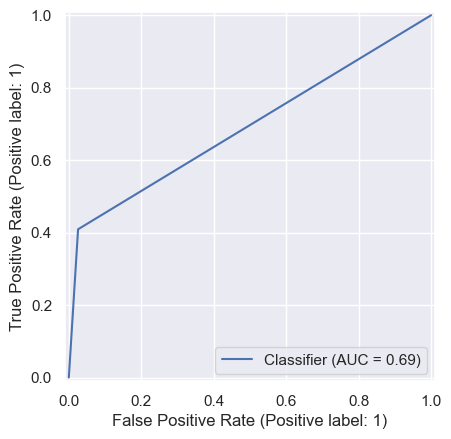

In [4]:
# Natrénovanie modelu 'RandomForestClassifier' na trénovacej podmnožine
model_RF = RandomForestClassifier(random_state=977, n_estimators=253, max_depth=9, min_samples_split=12, min_samples_leaf=5).fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_RF = model_RF.predict(x_test)

# Výpočet metrík AUC a ROC
auc_RF = roc_auc_score(y_test, y_pred_RF)
roc_RF = RocCurveDisplay.from_predictions(y_test, y_pred_RF)

# Výpis AUC
print(f"AUC pre RF: {auc_RF:.5f}")

# Vytvorenie matice zámen
cm_RF = confusion_matrix(y_test, y_pred_RF)

# Výpis classification report-u
print(classification_report(y_test, y_pred_RF, digits=5))

DecisionTreeClassifier

AUC pre DT: 0.68527
              precision    recall  f1-score   support

           0    0.86318   0.97447   0.91545      2389
           1    0.79868   0.39607   0.52954       611

    accuracy                        0.85667      3000
   macro avg    0.83093   0.68527   0.72250      3000
weighted avg    0.85004   0.85667   0.83686      3000



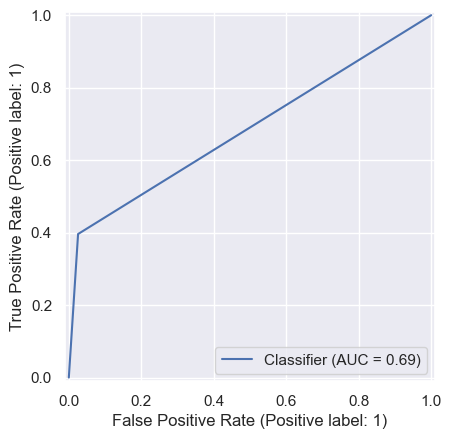

In [5]:
# Natrénovanie modelu 'DecisionTreeClassifier' na trénovacej podmnožine
model_DT = DecisionTreeClassifier(random_state=977, max_depth=6, min_samples_split=14, min_samples_leaf=9).fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_DT = model_DT.predict(x_test)

# Vytvorenie AUC a ROC
auc_DT = roc_auc_score(y_test, y_pred_DT)
roc_DT = RocCurveDisplay.from_predictions(y_test, y_pred_DT)

# Výpis AUC
print(f"AUC pre DT: {auc_DT:.5f}")

# Vytvorenie matice zámen
cm_DT = confusion_matrix(y_test, y_pred_DT)

# Výpis classification report-u
print(classification_report(y_test, y_pred_DT, digits=5)) 

LogisticRegressionCV

AUC pre LR: 0.56115
              precision    recall  f1-score   support

           0    0.81710   0.97991   0.89113      2389
           1    0.64444   0.14239   0.23324       611

    accuracy                        0.80933      3000
   macro avg    0.73077   0.56115   0.56219      3000
weighted avg    0.78194   0.80933   0.75714      3000



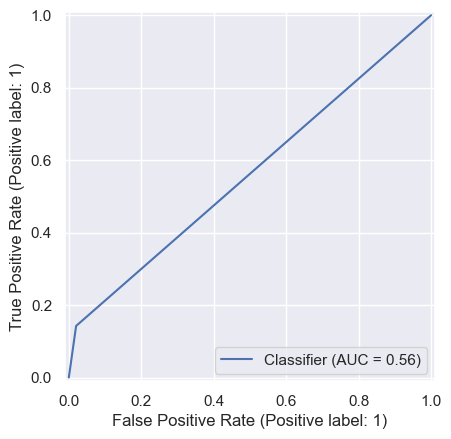

In [6]:
# Natrénovanie modelu 'LogisticRegressionCV' na trénovacej podmnožine
model_LR = LogisticRegressionCV(solver="saga", penalty="l2", Cs=[0.7686429806479687], random_state=977, max_iter=10000).fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_LR = model_LR.predict(x_test)

# Vytvorenie AUC a ROC
auc_LR = roc_auc_score(y_test, y_pred_LR)
roc_LR = RocCurveDisplay.from_predictions(y_test, y_pred_LR)

# Výpis AUC
print(f"AUC pre LR: {auc_LR:.5f}")

# Vytvorenie matice zámen
cm_LR = confusion_matrix(y_test, y_pred_LR)

# Výpis classification report-u
print(classification_report(y_test, y_pred_LR, digits=5))

MLP

AUC pre MLP: 0.65772
              precision    recall  f1-score   support

           0    0.85571   0.92591   0.88943      2389
           1    0.57349   0.38953   0.46394       611

    accuracy                        0.81667      3000
   macro avg    0.71460   0.65772   0.67668      3000
weighted avg    0.79823   0.81667   0.80277      3000



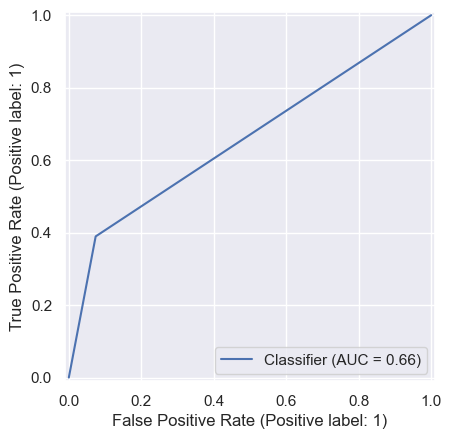

In [7]:
# Natrénovanie modelu 'MLPClassifier' na trénovacej podmnožine
model_MLP = MLPClassifier(solver="adam", learning_rate="constant", hidden_layer_sizes=(100,), alpha=0.05, activation="tanh", random_state=977).fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_MLP = model_MLP.predict(x_test)

# Vytvorenie AUC a ROC
auc_MLP = roc_auc_score(y_test, y_pred_MLP)
roc_MLP =  RocCurveDisplay.from_predictions(y_test, y_pred_MLP)

# Výpis AUC
print(f"AUC pre MLP: {auc_MLP:.5f}")

# Vytvorenie matice zámen
cm_MLP = confusion_matrix(y_test, y_pred_MLP)

# Výpis classification report-u
print(classification_report(y_test, y_pred_MLP, digits=5))

Nadvzorkovanie cez ADASYN

In [8]:
# Inicializácia ADASYN s definovanými parametrami
adasyn = ADASYN(sampling_strategy='minority', random_state=1, n_neighbors=7)

# Použitie ADASYN na vyváženie trénovacej sady
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)

# Vytvorenie nového DataFrame z nadvzorkovaných trénovacích dát
new_df = pd.DataFrame(x_train_adasyn, columns=x_train.columns)

Overenie nadvzorkovanie

In [9]:
y_train_1 = (y_train == 1).sum()
y_train_adasyn_1 = (y_train_adasyn == 1).sum()
y_train_0 = (y_train == 0).sum()
y_train_adasyn_0 = (y_train_adasyn == 0).sum()
sum_of_y_train = y_train_1 + y_train_0
sum_of_y_train_adasyn = y_train_adasyn_1 + y_train_adasyn_0

y_test_1 = (y_test == 1).sum()
y_test_0 = (y_test == 0).sum()
sum_of_y_test = y_test_1 + y_test_0

change_1 = y_train_adasyn_1 - y_train_1
change_0 = y_train_adasyn_0 - y_train_0

df_0 = df[df["churn"]==0].value_counts().sum()
df_1 = df[df["churn"]==1].value_counts().sum()

if (y_train_adasyn_1 > y_train_1) and (y_train_0 == y_train_adasyn_0):
    print(f"Nadvzorkovanie prebehlo úspešne.\ny_train_1: {y_train_1} | y_train_adasyn_1: {y_train_adasyn_1} | Navýšenie o: {change_1}\n"
          f"y_train_0: {y_train_0} | y_train_adasyn_0: {y_train_adasyn_0} | Navýšenie o: {change_0}")
else:
    print("!!!CHYBA!!!\nNadvzorkovanie neprebehlo úspešne")

print(f"0: {y_test_0} + ADASYN 0: {y_train_adasyn_0} = {y_test_0 + y_train_adasyn_0}")
print(f"1: {y_test_1} + ADASYN 1: {y_train_adasyn_1} = {y_test_1 + y_train_adasyn_1}")

print(f"\nPočetnosť záznamov v oboch triedach cieľového atribútu PRED nadvzorkovaním:\n 0: {df_0} | 1: {df_1}")

print(f"Nový dataset má {sum_of_y_train_adasyn + sum_of_y_test} záznamov.")

Nadvzorkovanie prebehlo úspešne.
y_train_1: 1426 | y_train_adasyn_1: 5423 | Navýšenie o: 3997
y_train_0: 5574 | y_train_adasyn_0: 5574 | Navýšenie o: 0
0: 2389 + ADASYN 0: 5574 = 7963
1: 611 + ADASYN 1: 5423 = 6034

Početnosť záznamov v oboch triedach cieľového atribútu PRED nadvzorkovaním:
 0: 7963 | 1: 2037
Nový dataset má 13997 záznamov.


# Modely po nadvzorkovaní

RandomForestClassifier

AUC pre RF(ADASYN):0.73749
              precision    recall  f1-score   support

           0    0.90090   0.83340   0.86584      2389
           1    0.49620   0.64157   0.55960       611

    accuracy                        0.79433      3000
   macro avg    0.69855   0.73749   0.71272      3000
weighted avg    0.81848   0.79433   0.80347      3000



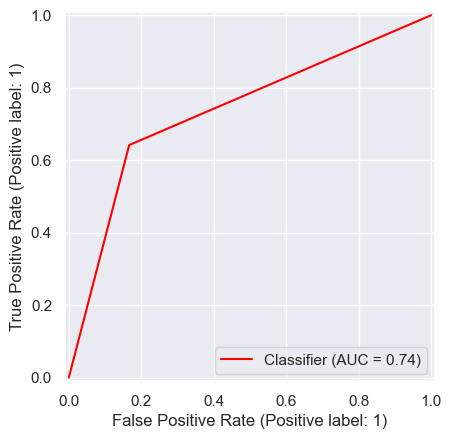

In [10]:
# Natrénovanie modelu 'RandomForestClassifier' na trénovacej podmnožine
model_adasyn_RF = RandomForestClassifier(random_state=977, n_estimators=253, max_depth=9, min_samples_split=12, min_samples_leaf=5).fit(x_train_adasyn, y_train_adasyn)

# Predikcia modelu na testovacej množine
y_pred_adasyn_RF = model_adasyn_RF.predict(x_test)

# Vytvorenie AUC a ROC
auc_adasyn_RF = roc_auc_score(y_test, y_pred_adasyn_RF)
roc_adasyn_RF = RocCurveDisplay.from_predictions(y_test, y_pred_adasyn_RF, color="red")

# Výpis AUC
print(f"AUC pre RF(ADASYN):{auc_adasyn_RF:.5f}")

# Výpis classification report-u
cm_adasyn_RF = confusion_matrix(y_test, y_pred_adasyn_RF)
print(classification_report(y_test, y_pred_adasyn_RF, digits=5))

In [13]:
def find_best_hypparams(trial):
    # Navrhnutie hyperparametrov
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Vytvorenie a trénovanie modelu
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=977
    )
    model.fit(x_train_adasyn, y_train_adasyn)
    
    # Predikcia a výpočet AUC
    y_pred = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Vytvorenie štúdie a spustenie optimalizácie
study = optuna.create_study(direction='maximize')
study.optimize(find_best_hypparams, n_trials=100)

# Výpis najlepších hyperparametrov
print("Najlepšie hyperparametre:", study.best_params)

# Vytvorenie modelu s najlepšími hyperparametrami
best_model = RandomForestClassifier(**study.best_params, random_state=977)
best_model.fit(x_train_adasyn, y_train_adasyn)

# Predikcia a výpočet AUC pre najlepší model
y_pred_best = best_model.predict(x_test)
auc_best = roc_auc_score(y_test, y_pred_best)
print(f"AUC pre najlepší RF(ADASYN): {auc_best:.5f}")

[I 2024-05-20 21:06:23,037] A new study created in memory with name: no-name-ad3dd88d-6b52-4c10-80a8-0231f6b619f6
[I 2024-05-20 21:06:24,106] Trial 0 finished with value: 0.7307479932231676 and parameters: {'n_estimators': 86, 'max_depth': 23, 'min_samples_split': 13, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7307479932231676.
[I 2024-05-20 21:06:24,927] Trial 1 finished with value: 0.7340778349212396 and parameters: {'n_estimators': 55, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7340778349212396.
[I 2024-05-20 21:06:27,191] Trial 2 finished with value: 0.7269451023135908 and parameters: {'n_estimators': 219, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.7340778349212396.
[I 2024-05-20 21:06:27,842] Trial 3 finished with value: 0.7184771446324842 and parameters: {'n_estimators': 110, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 1 with value: 

Najlepšie hyperparametre: {'n_estimators': 246, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}
AUC pre najlepší RF(ADASYN): 0.73859


DecisionTreeClassifier

AUC pre DT(ADASYN):0.72959
              precision    recall  f1-score   support

           0    0.90380   0.78652   0.84109      2389
           1    0.44625   0.67267   0.53655       611

    accuracy                        0.76333      3000
   macro avg    0.67503   0.72959   0.68882      3000
weighted avg    0.81061   0.76333   0.77907      3000



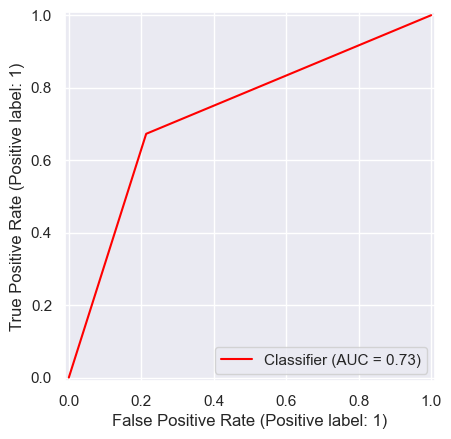

In [11]:
# Natrénovanie modelu 'DecisionTreeClassifier' na trénovacej podmnožine
model_adasyn_DT = DecisionTreeClassifier(random_state=977, max_depth=6, min_samples_split=14, min_samples_leaf=9).fit(x_train_adasyn, y_train_adasyn)

# Predikcia modelu na testovacej množine
y_pred_adasyn_DT = model_adasyn_DT.predict(x_test)

# Vytvorenie AUC a ROC
auc_adasyn_DT = roc_auc_score(y_test, y_pred_adasyn_DT)
roc_adasyn_DT = RocCurveDisplay.from_predictions(y_test, y_pred_adasyn_DT, color="red")

# Výpis AUC
print(f"AUC pre DT(ADASYN):{auc_adasyn_DT:.5f}")

# Vytvorenie matice zámen
cm_adasyn_DT = confusion_matrix(y_test, y_pred_adasyn_DT)

# Výpis classification report-u
print(classification_report(y_test, y_pred_adasyn_DT, digits=5))

In [15]:
def find_best_hypparams(trial):
    # Navrhnutie hyperparametrov
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Vytvorenie a trénovanie modelu
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=977
    )
    model.fit(x_train_adasyn, y_train_adasyn)
    
    # Predikcia a výpočet AUC
    y_pred = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)

    return auc

# Vytvorenie štúdie a spustenie optimalizácie
study = optuna.create_study(direction='maximize')
study.optimize(find_best_hypparams, n_trials=100)

# Výpis najlepších hyperparametrov
print("Najlepšie hyperparametre:", study.best_params)

# Vytvorenie modelu s najlepšími hyperparametrami
best_model = DecisionTreeClassifier(**study.best_params, random_state=977)
best_model.fit(x_train_adasyn, y_train_adasyn)

# Predikcia a výpočet AUC pre najlepší model
y_pred_best = best_model.predict(x_test)
auc_best = roc_auc_score(y_test, y_pred_best)
print(f"AUC pre najlepší RF(ADASYN): {auc_best:.5f}")

[I 2024-05-20 21:13:48,912] A new study created in memory with name: no-name-72b98cd2-8c62-4157-9c60-b4a538498ee2
[I 2024-05-20 21:13:48,977] Trial 0 finished with value: 0.6917589415207042 and parameters: {'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6917589415207042.
[I 2024-05-20 21:13:49,015] Trial 1 finished with value: 0.7115516493694847 and parameters: {'max_depth': 8, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.7115516493694847.
[I 2024-05-20 21:13:49,054] Trial 2 finished with value: 0.729594657455509 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.729594657455509.
[I 2024-05-20 21:13:49,105] Trial 3 finished with value: 0.7269303730477729 and parameters: {'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.729594657455509.
[I 2024-05-20 21:13:49,167] Trial 4 finished with value: 0.67158738

Najlepšie hyperparametre: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9}
AUC pre najlepší RF(ADASYN): 0.72959


LogisticRegressionCV

AUC pre LR(ADASYN): 0.67399
              precision    recall  f1-score   support

           0    0.87897   0.75387   0.81163      2389
           1    0.38170   0.59411   0.46479       611

    accuracy                        0.72133      3000
   macro avg    0.63033   0.67399   0.63821      3000
weighted avg    0.77769   0.72133   0.74099      3000



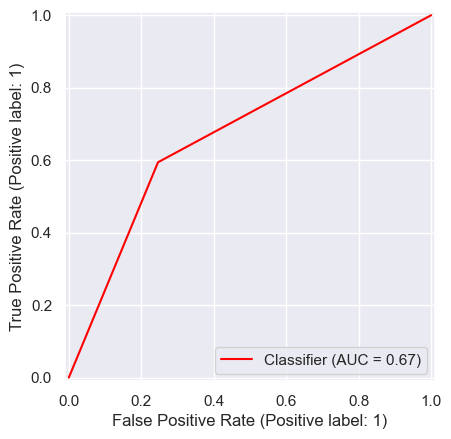

In [12]:
# Natrénovanie modelu 'LogisticRegressionCV' na trénovacej podmnožine
model_adasyn_LR = LogisticRegressionCV(solver="saga", penalty="l2", Cs=[0.7686429806479687], random_state=977, max_iter=10000).fit(x_train_adasyn, y_train_adasyn)

# Predikcia modelu na testovacej množine
y_pred_adasyn_LR = model_adasyn_LR.predict(x_test)

# Vytvorenie AUC a ROC
auc_adasyn_LR = roc_auc_score(y_test, y_pred_adasyn_LR)
roc_adasyn_LR = RocCurveDisplay.from_predictions(y_test, y_pred_adasyn_LR, color="red")

# Výpis AUC
print(f"AUC pre LR(ADASYN): {auc_adasyn_LR:.5f}")

# Vytvorenie matice zámen
cm_adasyn_LR = confusion_matrix(y_test, y_pred_adasyn_LR)

# Výpis classification report-u
print(classification_report(y_test, y_pred_adasyn_LR, digits=5))

In [18]:
max_iter = 1000000
def find_best_hypparams(trial):
    # Navrhnutie hyperparametrov
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'])
    penalty = trial.suggest_categorical('penalty', ['l2'])
    C = trial.suggest_float('C', 0.01, 10.0)
    
    # Ak je penalty 'elasticnet', potom navrhneme l1_ratio
    if penalty == 'elasticnet':
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    else:
        l1_ratio = None
    
    # Vytvorenie a trénovanie modelu
    model = LogisticRegressionCV(
        solver=solver,
        penalty=penalty,
        Cs=[C],
        l1_ratios=[l1_ratio] if l1_ratio is not None else None,
        cv=5,
        random_state=977,
        max_iter=max_iter
    )
    model.fit(x_train_adasyn, y_train_adasyn)
    
    # Predikcia a výpočet AUC
    y_pred = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Vytvorenie štúdie a spustenie optimalizácie
study = optuna.create_study(direction='maximize')
study.optimize(find_best_hypparams, n_trials=100)

# Výpis najlepších hyperparametrov
print("Najlepšie hyperparametre:", study.best_params)

best_model = LogisticRegressionCV(
    solver=study.best_params['solver'],
    penalty=study.best_params['penalty'],
    Cs=[study.best_params['C']],
    cv=5,
    random_state=977,
    max_iter=max_iter
)
best_model.fit(x_train_adasyn, y_train_adasyn)

# Predikcia a výpočet AUC pre najlepší model
y_pred_best = best_model.predict(x_test)
auc_best = roc_auc_score(y_test, y_pred_best)
print(f"AUC pre najlepší model (LogisticRegressionCV): {auc_best:.5f}")

[I 2024-05-20 21:48:25,821] A new study created in memory with name: no-name-1b6e171e-9400-4fd1-bd65-85f29011e182
[I 2024-05-20 21:48:26,153] Trial 0 finished with value: 0.6710598700125164 and parameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 7.100179275863014}. Best is trial 0 with value: 0.6710598700125164.
[I 2024-05-20 21:48:46,314] Trial 1 finished with value: 0.6721440124849367 and parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 7.4786356979496595}. Best is trial 1 with value: 0.6721440124849367.
[I 2024-05-20 21:49:10,077] Trial 2 finished with value: 0.6739899662871083 and parameters: {'solver': 'saga', 'penalty': 'l2', 'C': 7.93534757916507}. Best is trial 2 with value: 0.6739899662871083.
[I 2024-05-20 21:49:31,356] Trial 3 finished with value: 0.6721440124849367 and parameters: {'solver': 'sag', 'penalty': 'l2', 'C': 6.8644354784331085}. Best is trial 2 with value: 0.6739899662871083.
[I 2024-05-20 21:49:34,264] Trial 4 finished with value: 0.6714784551946009 an

Najlepšie hyperparametre: {'solver': 'saga', 'penalty': 'l2', 'C': 7.93534757916507}
AUC pre najlepší model (LogisticRegressionCV): 0.67399


MLP

AUC pre MLP(ADASYN): 0.66524
              precision    recall  f1-score   support

           0    0.86488   0.84931   0.85702      2389
           1    0.44954   0.48118   0.46482       611

    accuracy                        0.77433      3000
   macro avg    0.65721   0.66524   0.66092      3000
weighted avg    0.78029   0.77433   0.77714      3000



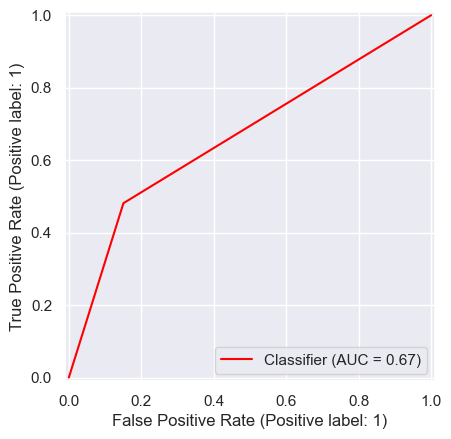

In [13]:
# Natrénovanie modelu 'MLPClassifier' na trénovacej podmnožine
model_adasyn_MLP = MLPClassifier(solver="adam", learning_rate="adaptive", hidden_layer_sizes=(100,), alpha=0.05, activation="tanh", random_state=977).fit(x_train_adasyn, y_train_adasyn)

# Predikcia modelu na testovacej množine
y_pred_adasyn_MLP = model_adasyn_MLP.predict(x_test)

# Vytvorenie AUC a ROC
auc_adasyn_MLP = roc_auc_score(y_test, y_pred_adasyn_MLP)
roc_adasyn_MLP =  RocCurveDisplay.from_predictions(y_test, y_pred_adasyn_MLP, color="red")

# Výpis AUC
print(f"AUC pre MLP(ADASYN): {auc_adasyn_MLP:.5f}")

# Vytvorenie matice zámen
cm_adasyn_MLP = confusion_matrix(y_test, y_pred_adasyn_MLP)

# Výpis classification report-u
print(classification_report(y_test, y_pred_adasyn_MLP, digits=5))

In [ ]:
def find_best_hypparams(trial):
    # Navrhnutie hyperparametrov
    solver = trial.suggest_categorical('solver', ['adam', 'sgd', 'lbfgs'])
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [50, 100, 50, 50, 100, 100])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    activation = trial.suggest_categorical('activation', ['tanh', 'relu', 'logistic'])
    
    # Vytvorenie a trénovanie modelu
    model = MLPClassifier(
        solver=solver,
        learning_rate=learning_rate,
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        activation=activation,
        max_iter=max_iter,
        random_state=977
    )
    model.fit(x_train_adasyn, y_train_adasyn)
    
    # Predikcia a výpočet AUC
    y_pred = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Vytvorenie štúdie a spustenie optimalizácie
study = optuna.create_study(direction='maximize')
study.optimize(find_best_hypparams, n_trials=100)

# Výpis najlepších hyperparametrov
print("Najlepšie hyperparametre:", study.best_params)

# Vytvorenie modelu s najlepšími hyperparametrami
best_model = MLPClassifier(**study.best_params, random_state=977)
best_model.fit(x_train_adasyn, y_train_adasyn)

# Predikcia a výpočet AUC pre najlepší model
y_pred_best = best_model.predict(x_test)
auc_best = roc_auc_score(y_test, y_pred_best)
print(f"AUC pre najlepší MLP(ADASYN): {auc_best:.5f}")

# Zobrazenie ROC kriviek modelov pred a po nadvzorkovaní
---

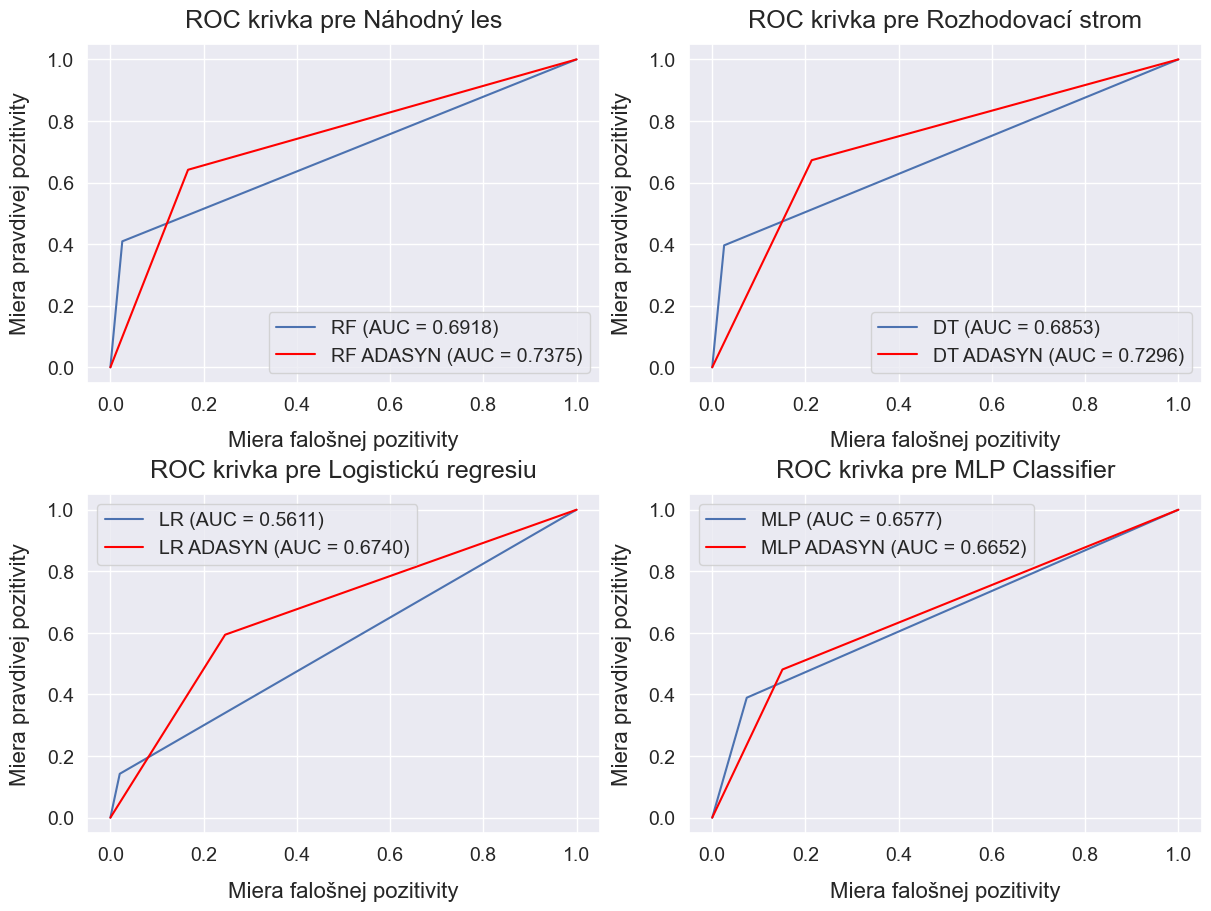

In [14]:
# Vytvorenie mriežky pre grafy
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 9))

# Graf ROC krivky pre model 'RandomForestClassifier' pred a po nadvzorkovaní
axs[0,0].plot(roc_RF.fpr, roc_RF.tpr, linestyle="solid", label=f"RF (AUC = {auc_RF:.4f})")
axs[0,0].plot(roc_adasyn_RF.fpr, roc_adasyn_RF.tpr, color="red", linestyle="solid", label=f"RF ADASYN (AUC = {auc_adasyn_RF:.4f})")
axs[0,0].set_title("ROC krivka pre Náhodný les", pad=12, fontsize=18)
axs[0,0].legend(fontsize=14)
axs[0,0].tick_params(axis="both", which="major", labelsize=14)

# Graf ROC krivky pre model 'DecisionTreeClassifier' pred a po nadvzorkovaní
axs[0,1].plot(roc_DT.fpr, roc_DT.tpr, linestyle="solid", label=f"DT (AUC = {auc_DT:.4f})")
axs[0,1].plot(roc_adasyn_DT.fpr, roc_adasyn_DT.tpr, color="red", linestyle="solid", label=f"DT ADASYN (AUC = {auc_adasyn_DT:.4f})")
axs[0,1].set_title("ROC krivka pre Rozhodovací strom", pad=12, fontsize=18)
axs[0,1].legend(fontsize=14)
axs[0,1].tick_params(axis="both", which="major", labelsize=14)

# Graf ROC krivky pre model 'LogisticRegressionCV' pred a po nadvzorkovaní
axs[1,0].plot(roc_LR.fpr, roc_LR.tpr, linestyle="solid", label=f"LR (AUC = {auc_LR:.4f})")
axs[1,0].plot(roc_adasyn_LR.fpr, roc_adasyn_LR.tpr, color="red", linestyle="solid", label=f"LR ADASYN (AUC = {auc_adasyn_LR:.4f})")
axs[1,0].set_title("ROC krivka pre Logistickú regresiu", pad=12, fontsize=18)
axs[1,0].legend(fontsize=14)
axs[1,0].tick_params(axis="both", which="major", labelsize=14)

# Graf ROC krivky pre model 'MLPClassifier' pred a po nadvzorkovaní
axs[1,1].plot(roc_MLP.fpr, roc_MLP.tpr, linestyle="solid", label=f"MLP (AUC = {auc_MLP:.4f})")
axs[1,1].plot(roc_adasyn_MLP.fpr, roc_adasyn_MLP.tpr, color="red", linestyle="solid", label=f"MLP ADASYN (AUC = {auc_adasyn_MLP:.4f})")
axs[1,1].set_title("ROC krivka pre MLP Classifier", pad=12, fontsize=18)
axs[1,1].legend(fontsize=14)
axs[1,1].tick_params(axis="both", which="major", labelsize=14)

# Nastavenie popisov osí pre všetky grafy
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("Miera falošnej pozitivity", fontsize=16, labelpad=12)
        axs[i,j].set_ylabel("Miera pravdivej pozitivity", fontsize=16, labelpad=12)

plt.show()

Výpis výsledkov AUC a zistenie zlepšenia

In [15]:
# Výpis výsledkov AUC pre modely natrénované na nenadvzorkovanom datasete
print(f"AUC pred nadvzorkovaním pomocou ADASYN:\nRF: {auc_RF:.4f} | DT: {auc_DT:.4f} | LR: {auc_LR:.4f} | MLP: {auc_MLP:.4f}")

# Výpis výsledkov AUC pre modely natrénované na nadvzorkovanom datasete
print(f"AUC po nadvzorkovaním pomocou ADASYN:\nRF: {auc_adasyn_RF:.4f} | DT: {auc_adasyn_DT:.4f} | LR: {auc_adasyn_LR:.4f} | MLP: {auc_adasyn_MLP:.4f}")

# Výpis zlepšenia výsledkov AUC pre oba prístupy
print(f"Zlepšenie:\nRF: {(auc_adasyn_RF-auc_RF):.4f} | DT: {(auc_adasyn_DT-auc_DT):.4f} | LR: {(auc_adasyn_LR-auc_LR):.4f} | MLP: {(auc_adasyn_MLP-auc_MLP):.4f}")

AUC pred nadvzorkovaním pomocou ADASYN:
RF: 0.6918 | DT: 0.6853 | LR: 0.5611 | MLP: 0.6577
AUC po nadvzorkovaním pomocou ADASYN:
RF: 0.7375 | DT: 0.7296 | LR: 0.6740 | MLP: 0.6652
Zlepšenie:
RF: 0.0457 | DT: 0.0443 | LR: 0.1128 | MLP: 0.0075


# Zobrazenie confusion matrix modelov pred a po nadvzorkovaní
---

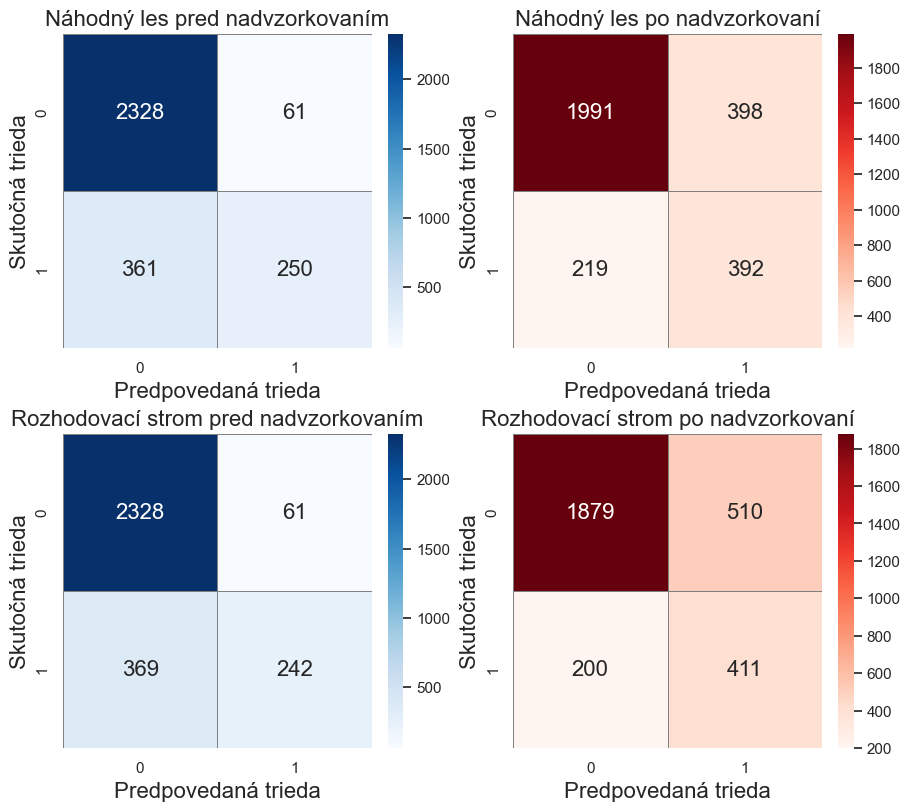

In [16]:
# Vytvorenie mriežky pre matice zámen
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9, 8))

# Nastavenie názvov pre jednotlivé matice
axs[0,0].set_title("Náhodný les pred nadvzorkovaním", fontsize=16)
axs[0,1].set_title("Náhodný les po nadvzorkovaní", fontsize=16)
axs[1,0].set_title("Rozhodovací strom pred nadvzorkovaním", fontsize=16)
axs[1,1].set_title("Rozhodovací strom po nadvzorkovaní", fontsize=16)

# Vykreslenie matíc zámen pre modely 'RandomForestClassifier' a 'DecisionTreeClassifier' pred a po nadvzorkovaní
sns.heatmap(cm_RF, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[0,0])
sns.heatmap(cm_adasyn_RF, annot=True, fmt="d", cmap="Reds", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[0,1])
sns.heatmap(cm_DT, annot=True,fmt="d", cmap="Blues", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[1,0])
sns.heatmap(cm_adasyn_DT, annot=True, fmt="d", cmap="Reds", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[1,1])

# Nastavenie popisov osí pre všetky matice zámen
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("Predpovedaná trieda", fontsize=16)
        axs[i,j].set_ylabel("Skutočná trieda", fontsize=16)

plt.show()

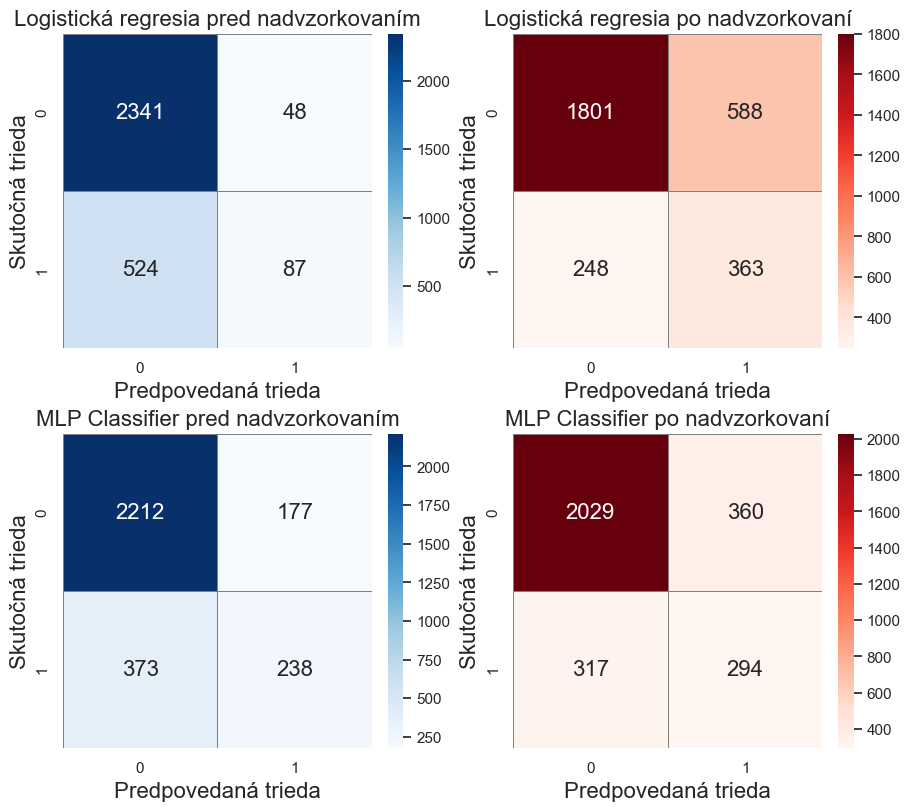

In [17]:
# Vytvorenie mriežky pre matice zámen
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9, 8))

# Nastavenie názvov pre jednotlivé matice
axs[0,0].set_title("Logistická regresia pred nadvzorkovaním", fontsize=16)
axs[0,1].set_title("Logistická regresia po nadvzorkovaní", fontsize=16)
axs[1,0].set_title("MLP Classifier pred nadvzorkovaním", fontsize=16)
axs[1,1].set_title("MLP Classifier po nadvzorkovaní", fontsize=16)

# Vytvorenie matíc zámen pre modely 'LogisticRegressionCV' a 'MLOClassifier' pred a po nadvzorkovaní
sns.heatmap(cm_LR, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[0,0])
sns.heatmap(cm_adasyn_LR, annot=True, fmt="d", cmap="Reds", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[0,1])
sns.heatmap(cm_MLP, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[1,0])
sns.heatmap(cm_adasyn_MLP, annot=True, fmt="d", cmap="Reds", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[1,1])

# Nastavenie popisov osí pre všetky matice zámen
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("Predpovedaná trieda", fontsize=16)
        axs[i,j].set_ylabel("Skutočná trieda", fontsize=16)

plt.show()

# Matice s váhami

In [18]:
# Funkcia, ktorá selektuje prípady z matíc zámen a priradzuje indexy váh
def calculate_sample_weights(y_true, y_pred, optimal_weights):
    sample_weights = []
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:  # TP
            sample_weights.append(optimal_weights[0])
        elif true == 0 and pred == 0:  # TN
            sample_weights.append(optimal_weights[1])
        elif true == 0 and pred == 1:  # FP
            sample_weights.append(optimal_weights[2])
        elif true == 1 and pred == 0:  # FN
            sample_weights.append(optimal_weights[3])
    return sample_weights

# Definovanie váh pre konkrétne prípady z matice zámen
optimal_weights = [0,5,-5,-10] # TP, TN, FP, FN

# Výpočet váh pre jednotlivé klasifikátory pred nadvzorkovaním
sample_weights_RF = calculate_sample_weights(y_test, y_pred_RF, optimal_weights)
sample_weights_DT = calculate_sample_weights(y_test, y_pred_DT, optimal_weights)
sample_weights_LR = calculate_sample_weights(y_test, y_pred_LR, optimal_weights)
sample_weights_MLP = calculate_sample_weights(y_test, y_pred_MLP, optimal_weights)

# Výpočet váh pre jednotlivé klasifikátory po nadvzorkovaní
sample_weights_adasyn_RF = calculate_sample_weights(y_test, y_pred_adasyn_RF, optimal_weights)
sample_weights_adasyn_DT = calculate_sample_weights(y_test, y_pred_adasyn_DT, optimal_weights)
sample_weights_adasyn_LR = calculate_sample_weights(y_test, y_pred_adasyn_LR, optimal_weights)
sample_weights_adasyn_MLP = calculate_sample_weights(y_test, y_pred_adasyn_MLP, optimal_weights)

# Výpočet váhovaných matic zámen pred nadvzorkovaním
cm_RF_w = confusion_matrix(y_test, y_pred_RF, sample_weight=sample_weights_RF)
cm_DT_w = confusion_matrix(y_test, y_pred_DT, sample_weight=sample_weights_DT)
cm_LR_w = confusion_matrix(y_test, y_pred_LR, sample_weight=sample_weights_LR)
cm_MLP_w = confusion_matrix(y_test, y_pred_MLP, sample_weight=sample_weights_MLP)

# Výpočet váhovaných matic zámen po nadvzorkovaní
cm_RF_adasyn_w = confusion_matrix(y_test, y_pred_adasyn_RF, sample_weight=sample_weights_adasyn_RF)
cm_DT_adasyn_w = confusion_matrix(y_test, y_pred_adasyn_DT, sample_weight=sample_weights_adasyn_DT)
cm_LR_adasyn_w = confusion_matrix(y_test, y_pred_adasyn_LR, sample_weight=sample_weights_adasyn_LR)
cm_MLP_adasyn_w = confusion_matrix(y_test, y_pred_adasyn_MLP, sample_weight=sample_weights_adasyn_MLP)

# Modely prispôsobené na nevyváženosť tried
---

EasyEnsembleClassifier

AUC pre EEC: 0.76653
              precision    recall  f1-score   support

           0    0.92200   0.79657   0.85470      2389
           1    0.48077   0.73650   0.58177       611

    accuracy                        0.78433      3000
   macro avg    0.70138   0.76653   0.71824      3000
weighted avg    0.83213   0.78433   0.79912      3000



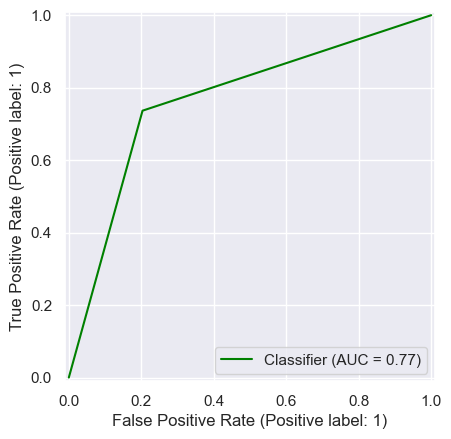

In [19]:
# Natrénovanie modelu 'EasyEnsembleClassifier' na trénovacej podmnožine
model_EEC = EasyEnsembleClassifier(random_state=977, estimator=model_RF).fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_EEC = model_EEC.predict(x_test)

# Vytvorenie AUC a ROC
auc_EEC = roc_auc_score(y_test, y_pred_EEC)
roc_EEC = RocCurveDisplay.from_predictions(y_test, y_pred_EEC, color="green")

# Výpis AUC
print(f"AUC pre EEC: {auc_EEC:.5f}")

# Vytvorenie matice zámen
cm_EEC = confusion_matrix(y_test, y_pred_EEC)

# Výpis classification report-u
print(classification_report(y_test, y_pred_EEC, digits=5))

BalancedBaggingClassifier

AUC pre BBC: 0.76800
              precision    recall  f1-score   support

           0    0.91906   0.81750   0.86531      2389
           1    0.50171   0.71849   0.59085       611

    accuracy                        0.79733      3000
   macro avg    0.71039   0.76800   0.72808      3000
weighted avg    0.83406   0.79733   0.80941      3000



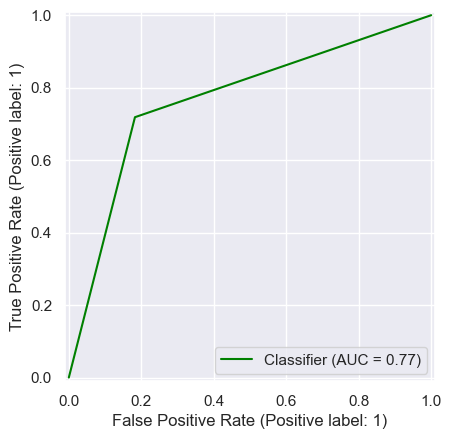

In [20]:
# Natrénovanie modelu 'BalancedBaggingClassifier' na trénovacej podmnožine
model_BBC = BalancedBaggingClassifier(random_state=977, estimator=model_RF).fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_BBC = model_BBC.predict(x_test)

# Vytvorenie AUC a ROC
auc_BBC = roc_auc_score(y_test, y_pred_BBC)
roc_BBC = RocCurveDisplay.from_predictions(y_test, y_pred_BBC, color="green")

# Výpis AUC
print(f"AUC pre BBC: {auc_BBC:.5f}")

# Vytvorenie matice zámen
cm_BBC = confusion_matrix(y_test, y_pred_BBC)

# Výpis classification report-u
print(classification_report(y_test, y_pred_BBC, digits=5))

BaggingClassifier

AUC pre BC: 0.68447
              precision    recall  f1-score   support

           0    0.86275   0.97614   0.91595      2389
           1    0.80808   0.39280   0.52863       611

    accuracy                        0.85733      3000
   macro avg    0.83541   0.68447   0.72229      3000
weighted avg    0.85161   0.85733   0.83706      3000



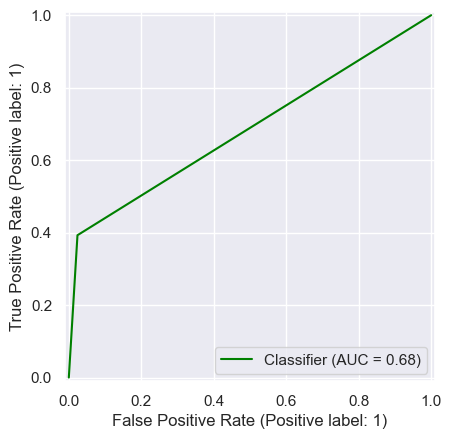

In [21]:
# Natrénovanie modelu 'BaggingClassifier' na trénovacej podmnožine
model_BC = BaggingClassifier(random_state=977, estimator=model_RF).fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_BC = model_BC.predict(x_test)

# Vytvorenie AUC a ROC
auc_BC = roc_auc_score(y_test, y_pred_BC)
roc_BC = RocCurveDisplay.from_predictions(y_test, y_pred_BC, color="green")

# Výpis AUC
print(f"AUC pre BC: {auc_BC:.5f}")

# Vytvorenie matice zámen
cm_BC = confusion_matrix(y_test, y_pred_BC)

# Výpis classification report-u
print(classification_report(y_test, y_pred_BC, digits=5))

AdaBoostClassifier

AUC pre ABC: 0.70832
              precision    recall  f1-score   support

           0    0.87962   0.89619   0.88783      2389
           1    0.56184   0.52046   0.54036       611

    accuracy                        0.81967      3000
   macro avg    0.72073   0.70832   0.71409      3000
weighted avg    0.81490   0.81967   0.81706      3000



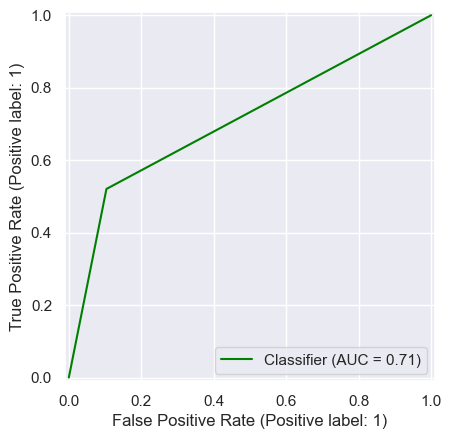

In [22]:
# Natrénovanie modelu 'AdaBoostClassifier' na trénovacej podmnožine
model_ABC = AdaBoostClassifier(random_state=977, estimator=model_RF, algorithm="SAMME").fit(x_train, y_train)

# Predikcia modelu na testovacej množine
y_pred_ABC = model_ABC.predict(x_test)

# Vytvorenie AUC a ROC
auc_ABC = roc_auc_score(y_test, y_pred_ABC)
roc_ABC = RocCurveDisplay.from_predictions(y_test, y_pred_ABC, color="green")

# Výpis AUC
print(f"AUC pre ABC: {auc_ABC:.5f}")

# Vytvorenie matice zámen
cm_ABC = confusion_matrix(y_test, y_pred_ABC)

# Výpis classification report-u
print(classification_report(y_test, y_pred_ABC, digits=5))

# Zobrazenie ROC kriviek modelov prispôsobených na nevyváženosť tried
---

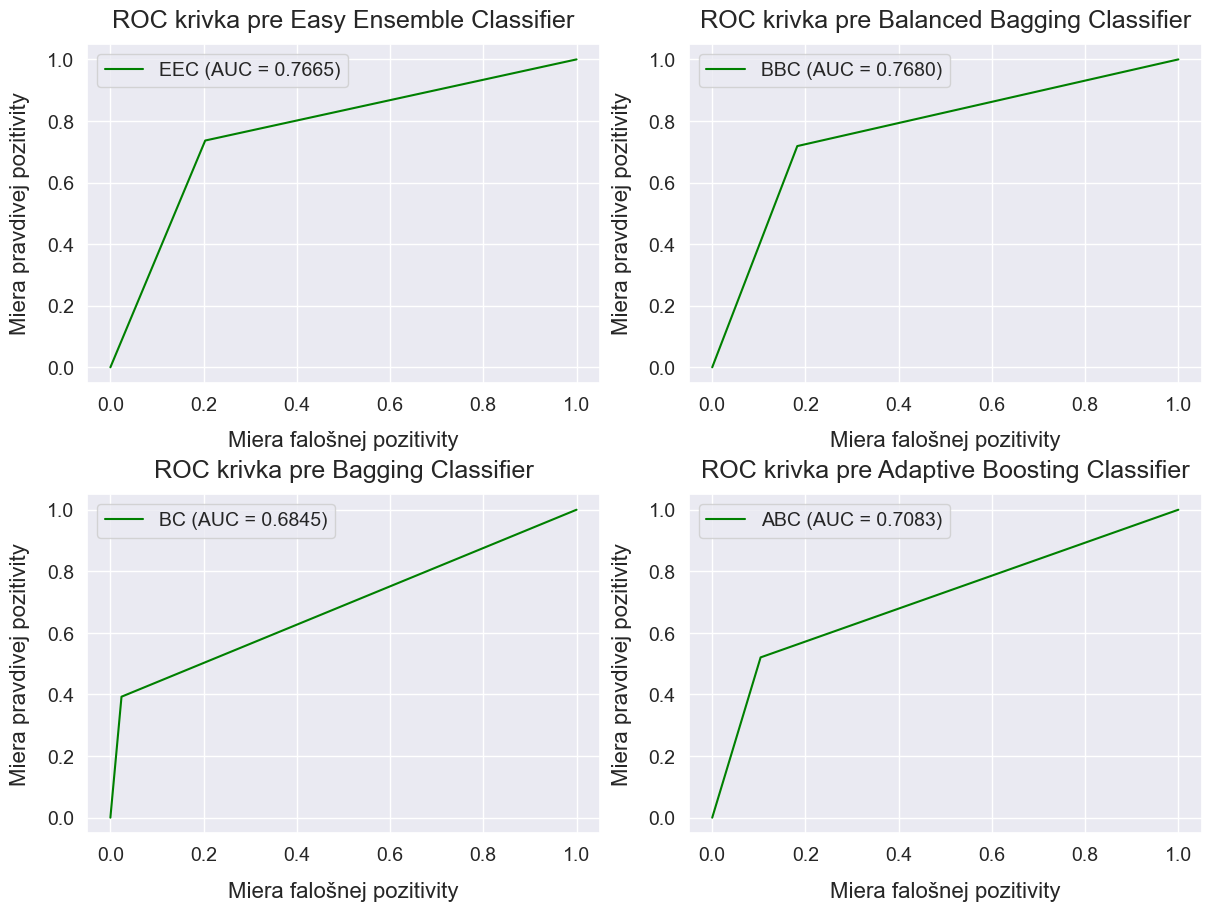

In [23]:
# Vytvorenie mriežky pre grafy
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12, 9))

# Graf ROC krivky pre model 'EasyEnsembleClassifier'
axs[0,0].plot(roc_EEC.fpr, roc_EEC.tpr, linestyle="solid", color="green", label=f"EEC (AUC = {auc_EEC:.4f})")
axs[0,0].set_title("ROC krivka pre Easy Ensemble Classifier", pad=12, fontsize=18)
axs[0,0].legend(fontsize=14)
axs[0,0].tick_params(axis='both', which='major', labelsize=14)

# Graf ROC krivky pre model 'BalancedBaggingClassifier'
axs[0,1].plot(roc_BBC.fpr, roc_BBC.tpr, linestyle="solid", color="green", label=f"BBC (AUC = {auc_BBC:.4f})")
axs[0,1].set_title("ROC krivka pre Balanced Bagging Classifier", pad=12, fontsize=18)
axs[0,1].legend(fontsize=14)
axs[0,1].tick_params(axis='both', which='major', labelsize=14)

# Graf ROC krivky pre model 'BaggingClassifier'
axs[1,0].plot(roc_BC.fpr, roc_BC.tpr, linestyle="solid", color="green", label=f"BC (AUC = {auc_BC:.4f})")
axs[1,0].set_title("ROC krivka pre Bagging Classifier", pad=12, fontsize=18)
axs[1,0].legend(fontsize=14)
axs[1,0].tick_params(axis='both', which='major', labelsize=14)

# Graf ROC krivky pre model 'AdaBoostClassifier'
axs[1,1].plot(roc_ABC.fpr, roc_ABC.tpr, linestyle="solid", color="green", label=f"ABC (AUC = {auc_ABC:.4f})")
axs[1,1].set_title("ROC krivka pre Adaptive Boosting Classifier", pad=12, fontsize=18)
axs[1,1].legend(fontsize=14)
axs[1,1].tick_params(axis='both', which='major', labelsize=14)

# Nastavenie popisov osí pre všetky grafy
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("Miera falošnej pozitivity", fontsize=16, labelpad=12)
        axs[i,j].set_ylabel("Miera pravdivej pozitivity", fontsize=16, labelpad=12)

plt.show()

# Zobrazenie confusion matrix modelov prispôsobených na nevyváženosť tried
---

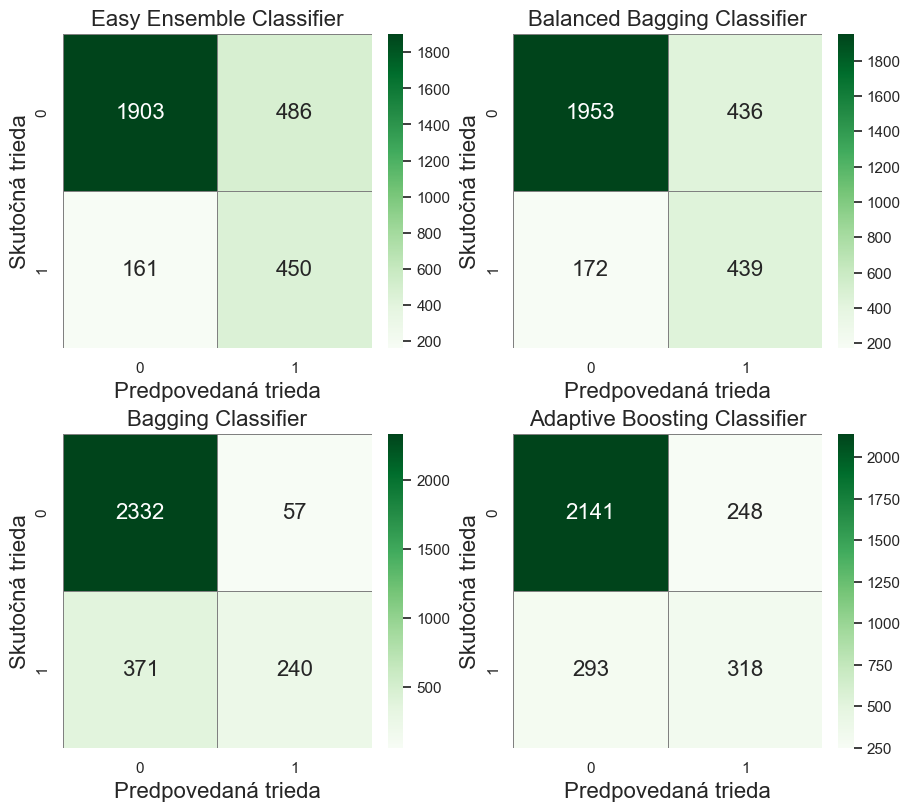

In [24]:
# Vytvorenie mriežky pre matice zámen
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9, 8))

# Nastavenie názvov pre jednotlivé matice
axs[0,0].set_title("Easy Ensemble Classifier", fontsize=16)
axs[0,1].set_title("Balanced Bagging Classifier", fontsize=16)
axs[1,0].set_title("Bagging Classifier", fontsize=16)
axs[1,1].set_title("Adaptive Boosting Classifier", fontsize=16)

# Vytvorenie matíc zámen pre modely 'EasyEnsembleClassifier', 'BalancedBaggingClassifier', 'BaggingClasiifier' a 'AdaBoostClassifier'
sns.heatmap(cm_EEC, annot=True, fmt="d", cmap="Greens", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[0,0])
sns.heatmap(cm_BBC, annot=True, fmt="d", cmap="Greens", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[0,1])
sns.heatmap(cm_BC, annot=True, fmt="d", cmap="Greens", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[1,0])
sns.heatmap(cm_ABC, annot=True, fmt="d", cmap="Greens", linewidths=0.5, linecolor="grey", annot_kws={"size": 16}, ax=axs[1,1])

# Nastavenie popisov osí pre všetky matice zámen
for i in range(2):
    for j in range(2):
        axs[i,j].set_xlabel("Predpovedaná trieda", fontsize=16)
        axs[i,j].set_ylabel("Skutočná trieda", fontsize=16)

plt.show()

# Matice s váhami

In [26]:
# Funkcia na priradenie váh jednotlivým prípadom z confusion matrix
def calculate_sample_weights(y_true, y_pred, optimal_weights):
    sample_weights = []
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:  # TP
            sample_weights.append(optimal_weights[0])
        elif true == 0 and pred == 0:  # TN
            sample_weights.append(optimal_weights[1])
        elif true == 0 and pred == 1:  # FP
            sample_weights.append(optimal_weights[2])
        elif true == 1 and pred == 0:  # FN
            sample_weights.append(optimal_weights[3])
    return sample_weights

# Definovanie váh pre prípady z confusion matrix
optimal_weights = [0,5,-5,-10]

# Priradenie váh na zákled výsledkov predikcií jedntlivých modelov a uloženie do premennej
sample_weights_EEC = calculate_sample_weights(y_test, y_pred_EEC, optimal_weights)
sample_weights_BBC = calculate_sample_weights(y_test, y_pred_BBC, optimal_weights)
sample_weights_BC = calculate_sample_weights(y_test, y_pred_BC, optimal_weights)
sample_weights_ABC = calculate_sample_weights(y_test, y_pred_ABC, optimal_weights)

# Vytvorenie váhovaných confusion matrix
cm_EEC_w = confusion_matrix(y_test, y_pred_EEC, sample_weight=sample_weights_EEC)
cm_BBC_w = confusion_matrix(y_test, y_pred_BBC, sample_weight=sample_weights_BBC)
cm_BC_w = confusion_matrix(y_test, y_pred_BC, sample_weight=sample_weights_BC)
cm_ABC_w = confusion_matrix(y_test, y_pred_ABC, sample_weight=sample_weights_ABC)

# Váhy

In [27]:
# Definícia váhových súčtov pre jednotlivé modely
weighted_sums = {
    "NORM": {
        "RF": {"sum": np.sum(cm_RF_w), "auc": auc_RF},
        "DT": {"sum": np.sum(cm_DT_w), "auc": auc_DT},
        "LR": {"sum": np.sum(cm_LR_w), "auc": auc_LR},
        "MLP": {"sum": np.sum(cm_MLP_w), "auc": auc_MLP}
    },
    "ADASYN": {
        "RF": {"sum": np.sum(cm_RF_adasyn_w), "auc": auc_adasyn_RF},
        "DT": {"sum": np.sum(cm_DT_adasyn_w), "auc": auc_adasyn_DT},
        "LR": {"sum": np.sum(cm_LR_adasyn_w), "auc": auc_adasyn_LR},
        "MLP": {"sum": np.sum(cm_MLP_adasyn_w), "auc": auc_adasyn_MLP}
    },
    "PRISPÔSOBENÉ": {
        "EEC": {"sum": np.sum(cm_EEC_w), "auc": auc_EEC},
        "BBC": {"sum": np.sum(cm_BBC_w), "auc": auc_BBC},
        "BC": {"sum": np.sum(cm_BC_w), "auc": auc_BC},
        "ABC": {"sum": np.sum(cm_ABC_w), "auc": auc_ABC}
    }
}

# Výpis váhových súčtov a AUC pre každý model
for dataset, models in weighted_sums.items():
    print(f"<-- {dataset} -->")
    for model, values in models.items():
        print(f"Suma váh pre {model}: {values['sum']} | AUC: {values['auc']:.3}")
    print()

# Nájdenie najlepšieho modelu na základe váhového súčtu
best_model, best_values = max(
    ((model, values) for models in weighted_sums.values() for model, values in models.items()),
    key=lambda x: x[1]['sum']
)

# Výpis výsledkov
print(f"Najlepší model je: {best_model} -> {best_values['sum']} | AUC: {best_values['auc']:.3}.")

<-- NORM -->
Suma váh pre RF: 7725 | AUC: 0.692
Suma váh pre DT: 7645 | AUC: 0.685
Suma váh pre LR: 6225 | AUC: 0.561
Suma váh pre MLP: 6445 | AUC: 0.658

<-- ADASYN -->
Suma váh pre RF: 5775 | AUC: 0.737
Suma váh pre DT: 4845 | AUC: 0.73
Suma váh pre LR: 3585 | AUC: 0.674
Suma váh pre MLP: 5175 | AUC: 0.665

<-- PRISPÔSOBENÉ -->
Suma váh pre EEC: 5475 | AUC: 0.767
Suma váh pre BBC: 5865 | AUC: 0.768
Suma váh pre BC: 7665 | AUC: 0.684
Suma váh pre ABC: 6535 | AUC: 0.708

Najlepší model je: RF -> 7725 | AUC: 0.692.


Funkcie

In [28]:
# Funkcia na získanie prípadov (TP, TN, FP, FN) z matice zámen
def extract_values_from_cm(confusion_matrix):
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[0][1]
    FN = confusion_matrix[1][0]
    TN = confusion_matrix[1][1]
    return TP, TN, FP, FN

# Funkcia na výpočet metrík (accuracy, precision, recall, f1-score) z matice zámen, ako argumenty berie 30% cieľového atribútu na testovanie a predikcie
def get_from_class_report(y_test, y_pred):
    acc = accuracy_score(y_true=y_test, y_pred=y_pred)*100
    prec = precision_score(y_true=y_test, y_pred=y_pred, average="macro")*100
    rec = recall_score(y_true=y_test, y_pred=y_pred, average="macro")*100
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average="macro")*100
    return acc, prec, rec, f1

# Funkcia na výpis metrík z matice zámen
def print_from_class_report(model, acc, prec, rec, f1):
    print(f"Model = {model} -> acc: {acc:.2f} | prec: {prec:.2f} | rec: {rec:.2f} | f1: {f1:.2f}")

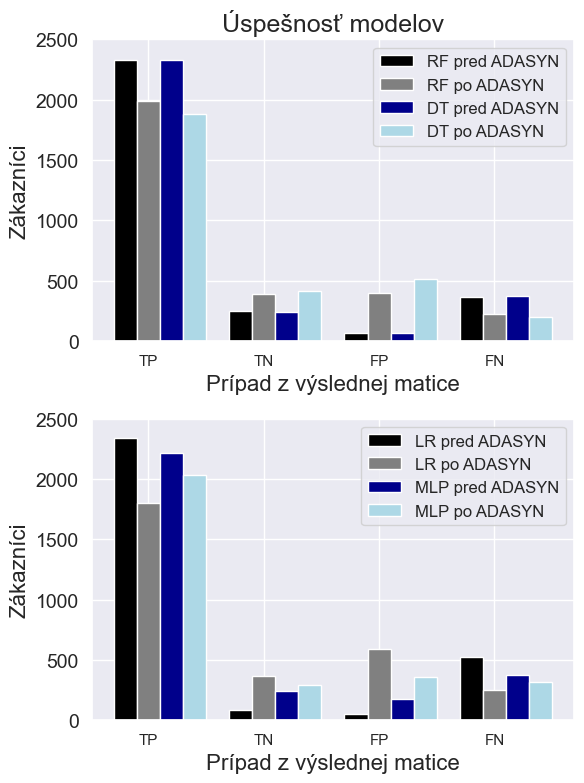

In [29]:
# Získanie a uloženie prípadov z matíc zámen pred nadvzorkovaním
TP_RF, TN_RF, FP_RF, FN_RF = extract_values_from_cm(cm_RF)
TP_DT, TN_DT, FP_DT, FN_DT = extract_values_from_cm(cm_DT)
TP_LR, TN_LR, FP_LR, FN_LR = extract_values_from_cm(cm_LR)
TP_MLP, TN_MLP, FP_MLP, FN_MLP = extract_values_from_cm(cm_MLP)

# Získanie a uloženie prípadov z matíc zámen po nadvzorkovaní
TP_adasyn_RF, TN_adasyn_RF, FP_adasyn_RF, FN_adasyn_RF = extract_values_from_cm(cm_adasyn_RF)
TP_adasyn_DT, TN_adasyn_DT, FP_adasyn_DT, FN_adasyn_DT = extract_values_from_cm(cm_adasyn_DT)
TP_adasyn_LR, TN_adasyn_LR, FP_adasyn_LR, FN_adasyn_LR = extract_values_from_cm(cm_adasyn_LR)
TP_adasyn_MLP, TN_adasyn_MLP, FP_adasyn_MLP, FN_adasyn_MLP = extract_values_from_cm(cm_adasyn_MLP)

# Vytvorenie poľa pozostávajúceho z premenných, kde sú uložené prípady z matíc zámen pred nadvzorkovaním
values_RF = [TP_RF, TN_RF, FP_RF, FN_RF]
values_DT = [TP_DT, TN_DT, FP_DT, FN_DT]
values_LR = [TP_LR, TN_LR, FP_LR, FN_LR]
values_MLP = [TP_MLP, TN_MLP, FP_MLP, FN_MLP]

# Vytvorenie poľa pozostávajúceho z premenných, kde sú uložené prípady z matíc zámen po nadvzorkovaní
values_adasyn_RF = [TP_adasyn_RF, TN_adasyn_RF, FP_adasyn_RF, FN_adasyn_RF]
values_adasyn_DT = [TP_adasyn_DT, TN_adasyn_DT, FP_adasyn_DT, FN_adasyn_DT]
values_adasyn_LR = [TP_adasyn_LR, TN_adasyn_LR, FP_adasyn_LR, FN_adasyn_LR]
values_adasyn_MLP = [TP_adasyn_MLP, TN_adasyn_MLP, FP_adasyn_MLP, FN_adasyn_MLP]

# Nastavenie pozícií a šírky stĺpcov
barWidth = 0.2
r1 = np.arange(len(values_RF))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Vytvorenie mriežky pre grafy
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

# Prvý subplot pre RF a DT
axs[0].bar(r1, values_RF, color="black", width=barWidth, edgecolor="white", label="RF pred ADASYN")
axs[0].bar(r2, values_adasyn_RF, color="grey", width=barWidth, edgecolor="white", label="RF po ADASYN")
axs[0].bar(r3, values_DT, color="darkblue", width=barWidth, edgecolor="white", label="DT pred ADASYN")
axs[0].bar(r4, values_adasyn_DT, color="lightblue", width=barWidth, edgecolor="white", label="DT po ADASYN")
axs[0].set_title("Úspešnosť modelov", fontsize=18)
axs[0].set_xlabel("Prípad z výslednej matice", fontsize=16)
axs[0].set_ylabel("Zákazníci", fontsize=16)
axs[0].set_xticks([r + barWidth for r in range(len(values_RF))])
axs[0].set_xticklabels(["TP", "TN", "FP", "FN"])
axs[0].set_yticks(np.arange(0, 2501, 500))
axs[0].set_yticklabels([str(i) for i in np.arange(0, 2501, 500)], fontsize=14)
axs[0].legend(fontsize=12)

# Druhý subplot pre LR a MLP
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
axs[1].bar(r1, values_LR, color="black", width=barWidth, edgecolor="white", label="LR pred ADASYN")
axs[1].bar(r2, values_adasyn_LR, color="grey", width=barWidth, edgecolor="white", label="LR po ADASYN")
axs[1].bar(r3, values_MLP, color="darkblue", width=barWidth, edgecolor="white", label="MLP pred ADASYN")
axs[1].bar(r4, values_adasyn_MLP, color="lightblue", width=barWidth, edgecolor="white", label="MLP po ADASYN")
axs[1].set_xlabel("Prípad z výslednej matice", fontsize=16)
axs[1].set_ylabel("Zákazníci", fontsize=16)
axs[1].set_xticks([r + barWidth for r in range(len(values_RF))])
axs[1].set_xticklabels(["TP", "TN", "FP", "FN"])
axs[1].set_yticks(np.arange(0, 2501, 500))
axs[1].set_yticklabels([str(i) for i in np.arange(0, 2501, 500)], fontsize=14)
axs[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

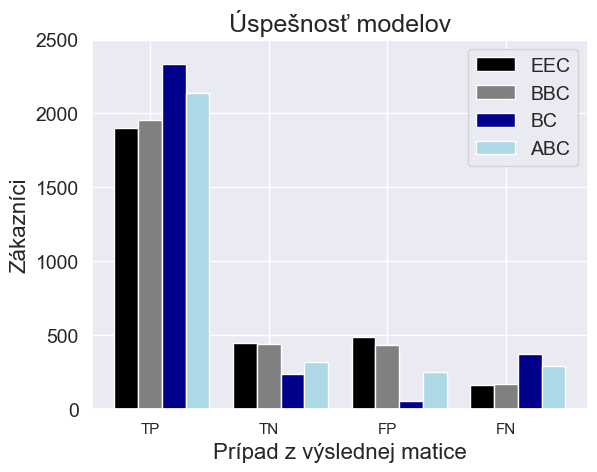

In [30]:
# Získanie a uloženie prípadov z matíc zámen pomocou funkcie
TP_EEC, TN_EEC, FP_EEC, FN_EEC = extract_values_from_cm(cm_EEC)
TP_BBC, TN_BBC, FP_BBC, FN_BBC = extract_values_from_cm(cm_BBC)
TP_BC, TN_BC, FP_BC, FN_BC = extract_values_from_cm(cm_BC)
TP_ABC, TN_ABC, FP_ABC, FN_ABC = extract_values_from_cm(cm_ABC)

# Vytvorenie poľa pozostávajúceho z premenných, kde sú uložené prípady z matíc zámen
values_EEC = [TP_EEC, TN_EEC, FP_EEC, FN_EEC]
values_BBC = [TP_BBC, TN_BBC, FP_BBC, FN_BBC]
values_BC = [TP_BC, TN_BC, FP_BC, FN_BC]
values_ABC = [TP_ABC, TN_ABC, FP_ABC, FN_ABC]

# Nastavenie pozícií a šírky stĺpcov
barWidth = 0.2
r1 = np.arange(len(values_EEC))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

sns.set()

# Zobrazenie grafov
plt.bar(r1, values_EEC, color="black", width=barWidth, edgecolor="white", label="EEC")
plt.bar(r2, values_BBC, color="grey", width=barWidth, edgecolor="white", label="BBC")
plt.bar(r3, values_BC, color="darkblue", width=barWidth, edgecolor="white", label="BC")
plt.bar(r4, values_ABC, color="lightblue", width=barWidth, edgecolor="white", label="ABC")
plt.title("Úspešnosť modelov", fontsize=18)
plt.xlabel("Prípad z výslednej matice", fontsize=16)
plt.ylabel("Zákazníci", fontsize=16)
plt.xticks([r + barWidth for r in range(len(values_RF))], ["TP", "TN", "FP", "FN"])
plt.yticks(np.arange(0, 2501, 500), [str(i) for i in np.arange(0, 2501, 500)], fontsize=14)
plt.legend(fontsize=14)

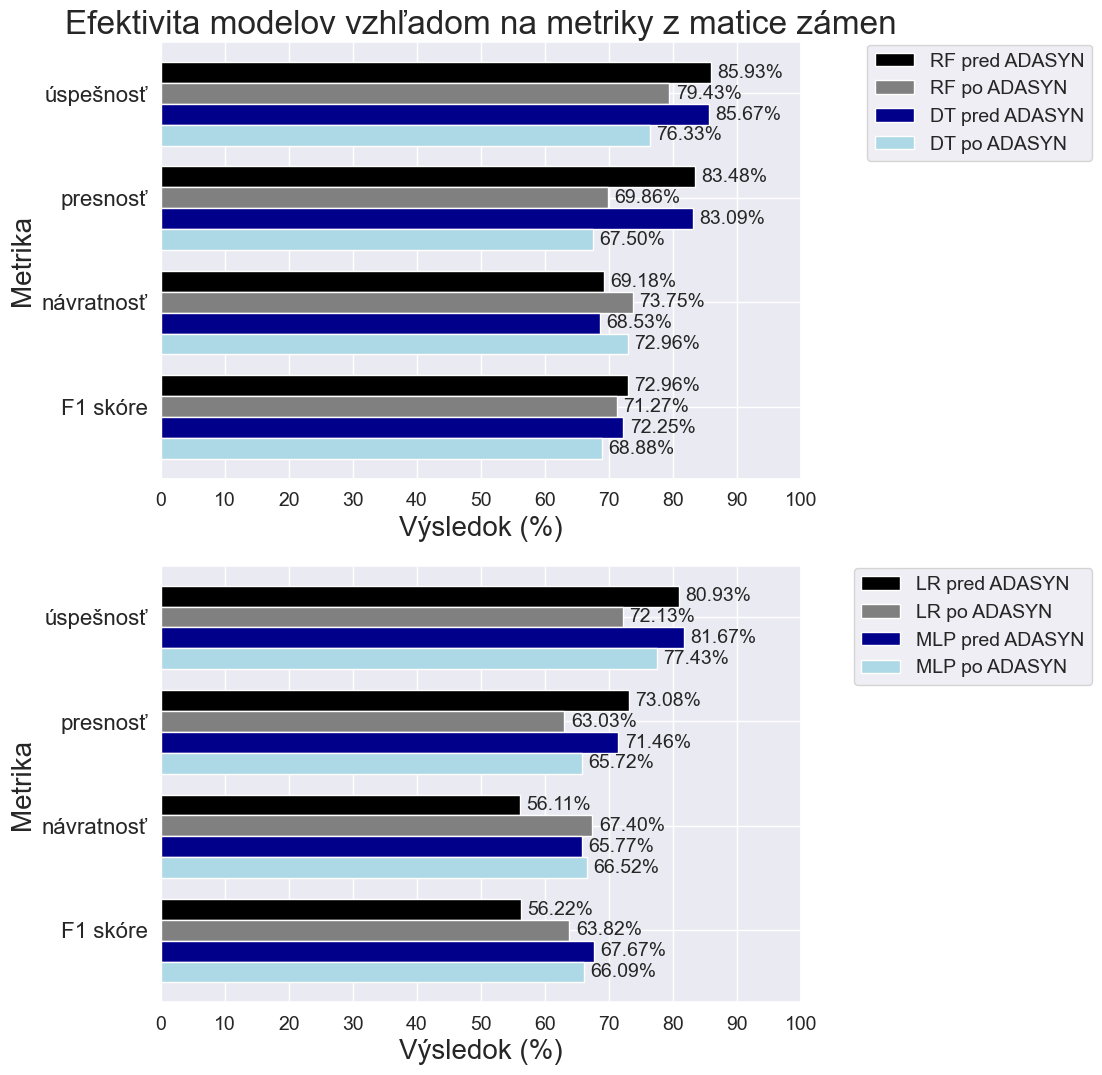

In [31]:
# Vypočítanie a uloženie metrík pred nadvzorkovaním pomocou funkcie
acc_RF, prec_RF, rec_RF, f1_RF = get_from_class_report(y_test, y_pred_RF)
acc_DT, prec_DT, rec_DT, f1_DT = get_from_class_report(y_test, y_pred_DT)
acc_LR, prec_LR, rec_LR, f1_LR = get_from_class_report(y_test, y_pred_LR)
acc_MLP, prec_MLP, rec_MLP, f1_MLP = get_from_class_report(y_test, y_pred_MLP)

# Vypočítanie a uloženie metrík po nadvzorkovaní pomocou funkcie
acc_adasyn_RF, prec_adasyn_RF, rec_adasyn_RF, f1_adasyn_RF = get_from_class_report(y_test, y_pred_adasyn_RF)
acc_adasyn_DT, prec_adasyn_DT, rec_adasyn_DT, f1_adasyn_DT = get_from_class_report(y_test, y_pred_adasyn_DT)
acc_adasyn_LR, prec_adasyn_LR, rec_adasyn_LR, f1_adasyn_LR = get_from_class_report(y_test, y_pred_adasyn_LR)
acc_adasyn_MLP, prec_adasyn_MLP, rec_adasyn_MLP, f1_adasyn_MLP = get_from_class_report(y_test, y_pred_adasyn_MLP)

# Vytvorenie poľa pozostávajúceho z premenných, kde sú uložené metriky z matíc zámen pred nadvzorkovaním
cr_RF = [acc_RF, prec_RF, rec_RF, f1_RF]
cr_DT = [acc_DT, prec_DT, rec_DT, f1_DT]
cr_LR = [acc_LR, prec_LR, rec_LR, f1_LR]
cr_MLP = [acc_MLP, prec_MLP, rec_MLP, f1_MLP]

# Vytvorenie poľa pozostávajúceho z premenných, kde sú uložené metriky z matíc zámen po nadvzorkovaní
cr_adasyn_RF = [acc_adasyn_RF, prec_adasyn_RF, rec_adasyn_RF, f1_adasyn_RF]
cr_adasyn_DT = [acc_adasyn_DT, prec_adasyn_DT, rec_adasyn_DT, f1_adasyn_DT]
cr_adasyn_LR = [acc_adasyn_LR, prec_adasyn_LR, rec_adasyn_LR, f1_adasyn_LR]
cr_adasyn_MLP = [acc_adasyn_MLP, prec_adasyn_MLP, rec_adasyn_MLP, f1_adasyn_MLP]

# Nastavenie pozícií a šírky stĺpcov
barWidth = 0.2
r1 = np.arange(len(values_RF))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Vytvorenie mriežky pre grafy
fig, axs = plt.subplots(2, 1, figsize=(8, 12))

# Prvý graf pre modely RF a DT pred a po nadvzorkovaní
axs[0].barh(r1, cr_RF, color="black", height=barWidth, edgecolor="white", label="RF pred ADASYN")
axs[0].barh(r2, cr_adasyn_RF, color="grey", height=barWidth, edgecolor="white", label="RF po ADASYN")
axs[0].barh(r3, cr_DT, color="darkblue", height=barWidth, edgecolor="white", label="DT pred ADASYN")
axs[0].barh(r4, cr_adasyn_DT, color="lightblue", height=barWidth, edgecolor="white", label="DT po ADASYN")
axs[0].set_title("Efektivita modelov vzhľadom na metriky z matice zámen", fontsize=24)
axs[0].set_ylabel("Metrika", fontsize=20)
axs[0].set_xlabel("Výsledok (%)", fontsize=20)
axs[0].set_yticks([r + barWidth for r in range(len(cr_RF))])
axs[0].set_yticklabels(["úspešnosť", "presnosť", "návratnosť", "F1 skóre"], fontsize = 16)
axs[0].set_xticks(np.arange(0, 101, 10))
axs[0].set_xticklabels([str(i) for i in np.arange(0, 101, 10)], fontsize=14)
axs[0].invert_yaxis()
axs[0].legend(loc="upper right", bbox_to_anchor=(1.47, 1.017), fontsize=14)

# Vypísanie dosiahnutých hodnôt pri metrikách (accuracy, precision, recall, f1-score) vedľa príslušného stĺpca
for i in range(len(r1)):
    axs[0].text(cr_RF[i] + 1, r1[i], f'{cr_RF[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs[0].text(cr_adasyn_RF[i] + 1, r2[i], f'{cr_adasyn_RF[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs[0].text(cr_DT[i] + 1, r3[i], f'{cr_DT[i]:.2f}%', ha='left', va="center", fontsize=14)
    axs[0].text(cr_adasyn_DT[i] + 1, r4[i], f'{cr_adasyn_DT[i]:.2f}%', ha="left", va="center", fontsize=14)

# Nastavenie šírky stĺpcov
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

# Druhý graf pre modely LR a MLP pred a po nadvzorkovaní
axs[1].barh(r1, cr_LR, color="black", height=barWidth, edgecolor="white", label="LR pred ADASYN")
axs[1].barh(r2, cr_adasyn_LR, color="grey", height=barWidth, edgecolor="white", label="LR po ADASYN")
axs[1].barh(r3, cr_MLP, color="darkblue", height=barWidth, edgecolor="white", label="MLP pred ADASYN")
axs[1].barh(r4, cr_adasyn_MLP, color="lightblue", height=barWidth, edgecolor="white", label="MLP po ADASYN")
axs[1].set_ylabel("Metrika", fontsize=20)
axs[1].set_xlabel("Výsledok (%)", fontsize=20)
axs[1].set_yticks([r + barWidth for r in range(len(cr_RF))])
axs[1].set_yticklabels(["úspešnosť", "presnosť", "návratnosť", "F1 skóre"], fontsize=16)
axs[1].set_xticks(np.arange(0, 101, 10))
axs[1].set_xticklabels([str(i) for i in np.arange(0, 101, 10)], fontsize=14)
axs[1].invert_yaxis()
axs[1].legend(loc="upper right", bbox_to_anchor=(1.47, 1.017), fontsize=14)

# Vypísanie dosiahnutých hodnôt pri metrikách (accuracy, precision, recall, f1-score) vedľa príslušného stĺpca
for i in range(len(r1)):
    axs[1].text(cr_LR[i] + 1, r1[i], f'{cr_LR[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs[1].text(cr_adasyn_LR[i] + 1, r2[i], f'{cr_adasyn_LR[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs[1].text(cr_MLP[i] + 1, r3[i], f'{cr_MLP[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs[1].text(cr_adasyn_MLP[i] + 1, r4[i], f'{cr_adasyn_MLP[i]:.2f}%', ha="left", va="center", fontsize=14)

# Úprava rozmerov grafu
plt.subplots_adjust(left=0.1,right=0.9,top=0.9,bottom=0.1)

plt.show()

Výpis metrík

In [32]:
print_from_class_report("RF", acc_RF, prec_RF, rec_RF, f1_RF)
print_from_class_report("DT", acc_DT, prec_DT, rec_DT, f1_DT)
print_from_class_report("LR", acc_LR, prec_LR, rec_LR, f1_LR)
print_from_class_report("MLP", acc_MLP, prec_MLP, rec_MLP, f1_MLP)
print(70*"-")
print_from_class_report("RF_adasyn", acc_adasyn_RF, prec_adasyn_RF, rec_adasyn_RF, f1_adasyn_RF)
print_from_class_report("DT_adasyn", acc_adasyn_DT, prec_adasyn_DT, rec_adasyn_DT, f1_adasyn_DT)
print_from_class_report("LR_adasyn", acc_adasyn_LR, prec_adasyn_LR, rec_adasyn_LR, f1_adasyn_LR)
print_from_class_report("MLP_adasyn", acc_adasyn_MLP, prec_adasyn_MLP, rec_adasyn_MLP, f1_adasyn_MLP)

Model = RF -> acc: 85.93 | prec: 83.48 | rec: 69.18 | f1: 72.96
Model = DT -> acc: 85.67 | prec: 83.09 | rec: 68.53 | f1: 72.25
Model = LR -> acc: 80.93 | prec: 73.08 | rec: 56.11 | f1: 56.22
Model = MLP -> acc: 81.67 | prec: 71.46 | rec: 65.77 | f1: 67.67
----------------------------------------------------------------------
Model = RF_adasyn -> acc: 79.43 | prec: 69.86 | rec: 73.75 | f1: 71.27
Model = DT_adasyn -> acc: 76.33 | prec: 67.50 | rec: 72.96 | f1: 68.88
Model = LR_adasyn -> acc: 72.13 | prec: 63.03 | rec: 67.40 | f1: 63.82
Model = MLP_adasyn -> acc: 77.43 | prec: 65.72 | rec: 66.52 | f1: 66.09


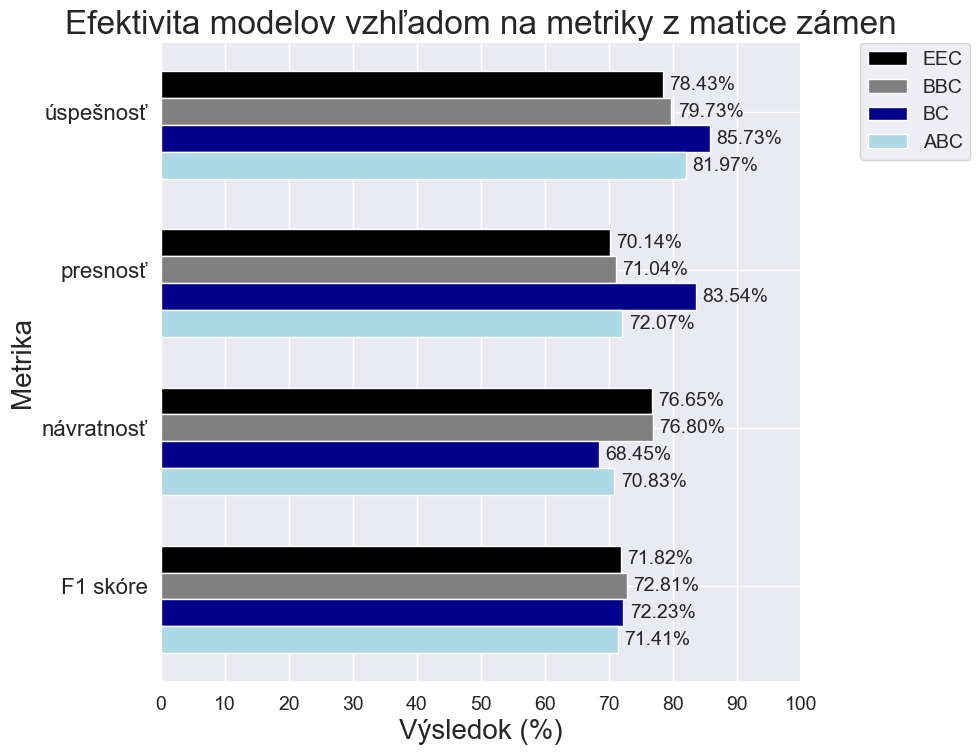

In [33]:
# Vypočítanie a uloženie metrík pomocou funkcie
acc_EEC, prec_EEC, rec_EEC, f1_EEC = get_from_class_report(y_test, y_pred_EEC)
acc_BBC, prec_BBC, rec_BBC, f1_BBC = get_from_class_report(y_test, y_pred_BBC)
acc_BC, prec_BC, rec_BC, f1_BC = get_from_class_report(y_test, y_pred_BC)
acc_ABC, prec_ABC, rec_ABC, f1_ABC = get_from_class_report(y_test, y_pred_ABC)

# Vytvorenie poľa pozostávajúceho z premenných, kde sú uložené metriky z matíc zámen
cr_EEC = [acc_EEC, prec_EEC, rec_EEC, f1_EEC]
cr_BBC = [acc_BBC, prec_BBC, rec_BBC, f1_BBC]
cr_BC = [acc_BC, prec_BC, rec_BC, f1_BC]
cr_ABC = [acc_ABC, prec_ABC, rec_ABC, f1_ABC]

# Nastavenie pozícií a šírky stĺpcov
barWidth = 0.17
r1 = np.arange(len(cr_EEC))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Vytvorenie mriežky pre grafy
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

# Grafy pre modely EEC, BBC, BC a ABC
axs.barh(r1, cr_EEC, color="black", height=barWidth, edgecolor="white", label="EEC")
axs.barh(r2, cr_BBC, color="grey", height=barWidth, edgecolor="white", label="BBC")
axs.barh(r3, cr_BC, color="darkblue", height=barWidth, edgecolor="white", label="BC")
axs.barh(r4, cr_ABC, color="lightblue", height=barWidth, edgecolor="white", label="ABC")
axs.set_title("Efektivita modelov vzhľadom na metriky z matice zámen", fontsize=24)
axs.set_ylabel("Metrika", fontsize=20)
axs.set_xlabel("Výsledok (%)", fontsize=20)
axs.set_yticks([r + barWidth for r in range(len(cr_EEC))])
axs.set_yticklabels(["úspešnosť", "presnosť", "návratnosť", "F1 skóre"], fontsize=16)
axs.set_xticks(np.arange(0, 101, 10))
axs.set_xticklabels([str(i) for i in np.arange(0, 101, 10)], fontsize=14)
axs.invert_yaxis()
axs.legend(loc='upper right', bbox_to_anchor=(1.28, 1.014), fontsize=14)

# Vypísanie dosiahnutých hodnôt pri metrikách (accuracy, precision, recall, f1-score) vedľa príslušného stĺpca
for i in range(len(r1)):
    axs.text(cr_EEC[i] + 1, r1[i], f'{cr_EEC[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs.text(cr_BBC[i] + 1, r2[i], f'{cr_BBC[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs.text(cr_BC[i] + 1, r3[i], f'{cr_BC[i]:.2f}%', ha="left", va="center", fontsize=14)
    axs.text(cr_ABC[i] + 1, r4[i], f'{cr_ABC[i]:.2f}%', ha="left", va="center", fontsize=14)

# Úprava rozmerov grafu
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.show()

Výpis metrík

In [34]:
print_from_class_report("EEC", acc_EEC, prec_EEC, rec_EEC, f1_EEC)
print_from_class_report("BBC", acc_BBC, prec_BBC, rec_BBC, f1_BBC)
print_from_class_report("BC", acc_BC, prec_BC, rec_BC, f1_BC)
print_from_class_report("ABC", acc_ABC, prec_ABC, rec_ABC, f1_ABC)

Model = EEC -> acc: 78.43 | prec: 70.14 | rec: 76.65 | f1: 71.82
Model = BBC -> acc: 79.73 | prec: 71.04 | rec: 76.80 | f1: 72.81
Model = BC -> acc: 85.73 | prec: 83.54 | rec: 68.45 | f1: 72.23
Model = ABC -> acc: 81.97 | prec: 72.07 | rec: 70.83 | f1: 71.41
